### Imports

In [1]:
import pyflux as pf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import statsmodels.tsa.api as smt
from datetime import datetime
from dateutil.parser import parse
import statsmodels.api as sm
from pylab import rcParams
from statsmodels.tsa.stattools import adfuller
%matplotlib inline
import matplotlib.patches as mpatches
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation
from sklearn.preprocessing import MinMaxScaler


def ts_diagnostics(y, lags=None, title='', filename=''):
    '''
    Calculate acf, pacf, qq plot and Augmented Dickey Fuller test for a given time series
    '''
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    # montly moving averages
    rolling_mean = y.rolling(window=30, center=False).mean()
    rolling_std = y.rolling(window=30, center=False).std()
    
    fig = plt.figure(figsize=(14, 12))
    layout = (3, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    qq_ax = plt.subplot2grid(layout, (2, 0))
    hist_ax = plt.subplot2grid(layout, (2, 1))
    
    # time series plot
    y.plot(ax=ts_ax)
    rolling_mean.plot(ax=ts_ax, color='crimson')
    rolling_std.plot(ax=ts_ax, color='darkslateblue')
    
    rollmean_patch = mpatches.Patch(color='crimson', label='Rolling Mean')
    rollstd_patch = mpatches.Patch(color='darkslateblue', label='Rolling Std')
    ts_ax.legend(handles=[rollmean_patch, rollstd_patch])
    ts_ax.set_title(title, fontsize=24);
    
    # acf and pacf
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5) 
    
    # qq plot
    sm.qqplot(y, line='s', ax=qq_ax)
    qq_ax.set_title('QQ Plot')
    
    # hist plot
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    plt.tight_layout()
    plt.show()
    
    # perform Augmented Dickey Fuller test
    print('Results of Dickey-Fuller test:')
    dftest = adfuller(y, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['test statistic', 'p-value', '# of lags', '# of observations'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    return

# Test stationarity base on Dickey-fuller Test
def test_stationarity(timeseries):  
    #Perform Dickey-Fuller test:
    print('Results of Augmented Dickey-Fuller test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['test statistic', 'p-value', '# of lags', '# of observations'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value ({})'.format(key)] = value
    print(dfoutput)
    
def test_stationarity_plot(timeseries):
    # Determing rolling statistics
    rolmean = timeseries.rolling(window=30, center=False).mean()
    rolstd = timeseries.rolling(window=30, center=False).std()
    # NOTE: moving mean and moving standard deviation — At any instant ‘t’, 
    # we take the mean/std of the last month which in this case is 30 days)
    
    # Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
# Function to show ACF, PACF and histogram
def tsplot(y, lags=None, title='', figsize=(14, 8)):
    '''Examine the patterns of ACF and PACF, along with the time series plot and histogram.
    
    Original source: https://tomaugspurger.github.io/modern-7-timeseries.html
    '''
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    #acf_ax  = plt.subplot2grid(layout, (1, 0))
    #pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    #smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    #smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    #[ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    plt.tight_layout()
    return ts_ax

def get_rmse(y, y_hat):
    '''Root Mean Square Error
    https://en.wikipedia.org/wiki/Root-mean-square_deviation
    '''
    mse = np.mean((y - y_hat)**2)
    return np.sqrt(mse)

def get_mape(y, y_hat):
    '''Mean Absolute Percent Error
    https://en.wikipedia.org/wiki/Mean_absolute_percentage_error
    '''
    perc_err = (100*(y - y_hat))/y
    return np.mean(abs(perc_err))

def get_mase(y, y_hat):
    '''Mean Absolute Scaled Error
    https://en.wikipedia.org/wiki/Mean_absolute_scaled_error
    '''
    abs_err = abs(y - y_hat)
    dsum=sum(abs(y[1:] - y_hat[1:]))
    t = len(y)
    denom = (1/(t - 1))* dsum
    return np.mean(abs_err/denom)

Using TensorFlow backend.


# Time Series is...
a sequence of measurements of the same variable collected over time.  Most often, the measurements are made at regular time intervals (e.g., hourly, daily, weekly, monthly, quarterly, annually). Irregularly spaced time series can also occur, but are beyond the scope of this talk. 

So for this talk let's assume that everything is where supposed to be.

![flash_distroiyng timelines](https://pm1.narvii.com/6482/9db9f819e6c218dc5fd457ad171a7966d7e83a42_hq.jpg)

# Are Time Series...
Nice examples of time series are: Quartely Beer Production on Australia, Daily IBM stock prices, Annual Rainfall. Other important thing about time series is that it can be decompose in patterns: 
  - Trend
  - Seasonality
  - Cycles
  - Combination of the above
  
# Problem
The problem we will try to solve will be: What will be the bitcoin's price? 

The goal here is not:
  - Spread the btc word 
  - Convence you to buy or sell
  - Talk about btc

The goal here is to show to present forecating models and show how to forecast a high-risk asset, whose price can unpredictably increase or decrease over a short period of time. Which can also be influenced by a wide range of factors. With tools available to anyone. 

But if you, as me, is full of btc, replace this by: What will be the weather tomorrow? What will be the price Apple stocks? Replace by anything you want.

# Data
We are gonna use a dataset from this site. You can download it anytime. It has the  daily price information of bitcoin from day 1 until August of 2017. And is measured in dollars.

I will be using this dataset because:
  - It's already pre-processed
  - There's no missing data
  - Was used in a kaggle competition
  - Represents a time of very incertity for the asset

In [2]:
data_location = '/home/sarai/Documents/data pybr/bitcoin-price-prediction/bitcoin_price_Training - bitcoin_price2013Apr-2017Aug.csv'
test_data_location = '/home/sarai/Documents/data pybr/bitcoin-price-prediction/bitcoin_price_1week_Test - bitcoin_price_Aug2017_1week (copy).csv'
what_really_happened_loc = '/home/sarai/Documents/data pybr/bitcoin-price-prediction/what_really_happened.csv'

raw_price_data = pd.read_csv(data_location)
raw_price_test_data = pd.read_csv(test_data_location)
what_really_happened = pd.read_csv(what_really_happened_loc)

raw_price_data.head()

,Date,Open,High,Low,Close,Volume,Market Cap
0,"Jul 31, 2017",2763.24,2889.62,2720.61,2875.34,"860,575,000","45,535,800,000"
1,"Jul 30, 2017",2724.39,2758.53,2644.85,2757.18,"705,943,000","44,890,700,000"
2,"Jul 29, 2017",2807.02,2808.76,2692.80,2726.45,"803,746,000","46,246,700,000"
3,"Jul 28, 2017",2679.73,2897.45,2679.73,2809.01,"1,380,100,000","44,144,400,000"
4,"Jul 27, 2017",2538.71,2693.32,2529.34,2671.78,"789,104,000","41,816,500,000"


In [3]:
raw_price_data.head()
what_really_happened.head()

,Date,Open,High,Low,Close,Volume,Market Cap
0,"Nov 07, 2017",7023.10,7253.32,7023.10,7144.38,"2,326,340,000","117,056,000,000"
1,"Nov 06, 2017",7403.22,7445.77,7007.31,7022.76,"3,111,900,000","123,379,000,000"
2,"Nov 05, 2017",7404.52,7617.48,7333.19,7407.41,"2,380,410,000","123,388,000,000"
3,"Nov 04, 2017",7164.48,7492.86,7031.28,7379.95,"2,483,800,000","119,376,000,000"
4,"Nov 03, 2017",7087.53,7461.29,7002.94,7207.76,"3,369,860,000","118,084,000,000"


### Set date as index

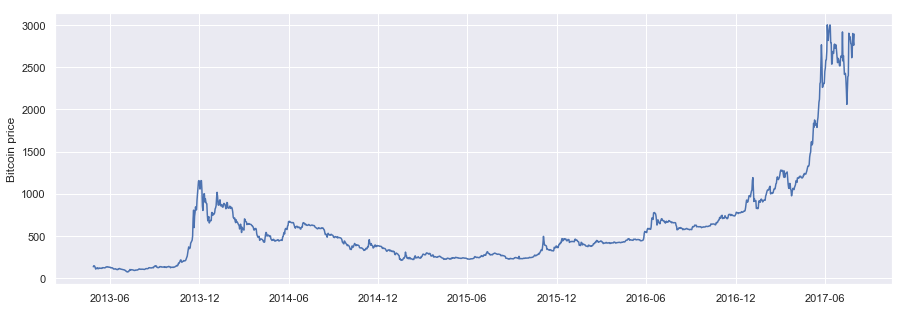

In [4]:
def convert(date):
    holder = []
    for i in date:
        tp = parse(i).timestamp()
        dt = datetime.fromtimestamp(tp)
        holder.append(dt)
    return np.array(holder)

raw_price_data = raw_price_data[::-1] 
date = raw_price_data['Date'].values
date_n = convert(date)
raw_price_data['Date'] = date_n
raw_price_data = raw_price_data.set_index('Date')

raw_price_test_data = raw_price_test_data[::-1]
date = raw_price_test_data['Date'].values
date_n = convert(date)
raw_price_test_data['Date'] = date_n
raw_price_test_data = raw_price_test_data.set_index('Date')

what_really_happened = what_really_happened[::-1]
date = what_really_happened['Date'].values
date_n = convert(date)
what_really_happened['Date'] = date_n
what_really_happened = what_really_happened.set_index('Date')

plt.figure(figsize=(15,5))
plt.plot(raw_price_data.index, raw_price_data['High'])
plt.ylabel('Bitcoin price');

## Graphics
Are there any trend, seasonality, cycles?
What are pattern of the ACF? Does it decline exponentially or dampen towards zero? Does it have a sharp cut-off?
What about the PACF?

On the top left there is the graph of bitcoin's price. On the top right there is the histogram graph, just for the histogram it's not possible to capture the time component of the time series, but analysing both graphs we can see a rising trend. The botton graphs show the dependency of the time series with itself. They're called autocorrelation graphs.

Autocorrelation -> How far back the series will give you information for the current value.
Partial Autocorrelation

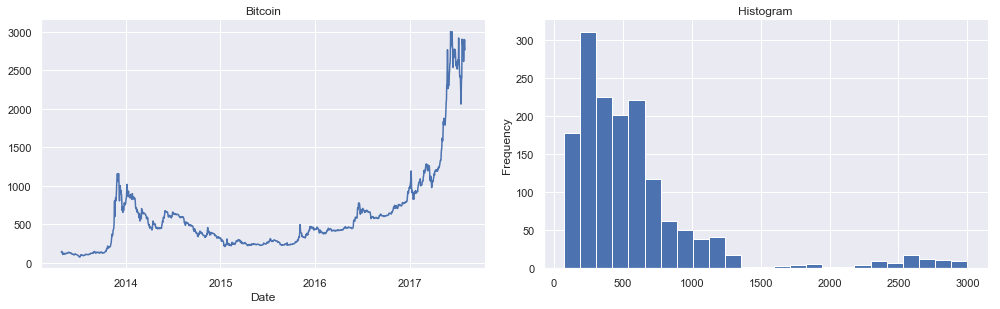

In [5]:
tsplot(raw_price_data['High'], title='Bitcoin', lags=70)

### Seasonal Decomposition

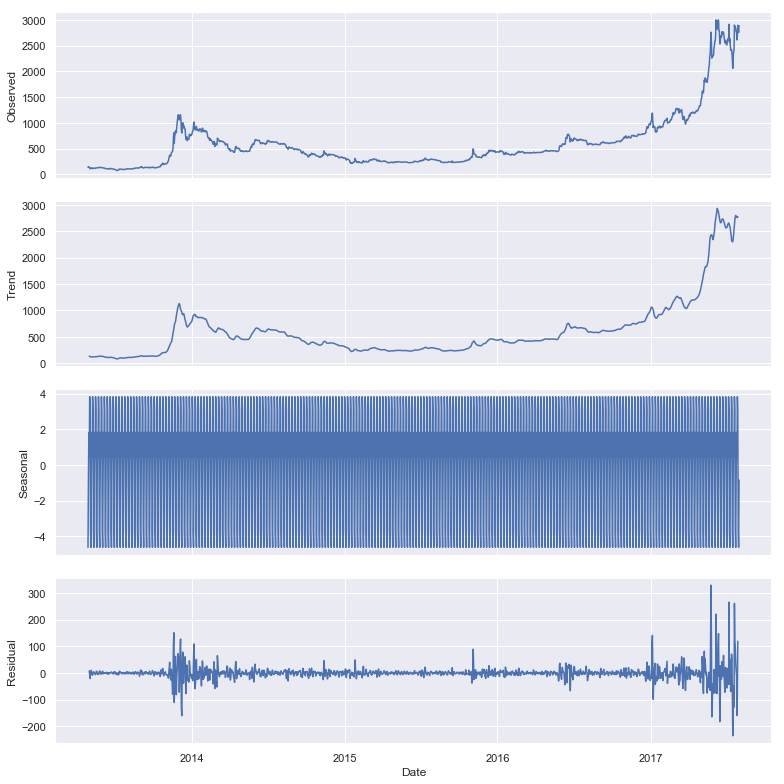

In [6]:
rcParams['figure.figsize'] = 11, 11

decomposition = sm.tsa.seasonal_decompose(raw_price_data['High'], model='additive')
fig = decomposition.plot()
plt.show()


# Forecasting Models
Some of the most important and commonly used data science techniques in time series forecasting are those developed in the field of machine learning and statistics.

# ARIMA

The ARIMA it's a univariate tecnique of time series analysis. Univariate means that the statistical relationship is unidirectional, which means a past information of the series it's used to forecast the future.

It's one of the most widely-used approaches to time series forecasting. ARIMA models aim to describe the autocorrelations in the data.

ARIMA stands for AutoRegressive Integrated Moving Average. It is a generalization of the simpler AutoRegressive Moving Average and adds the notion of integration. This acronym is descriptive, capturing the key aspects of the model itself. Briefly, they are:

**AR**: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.

**I**: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.

**MA**: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

Each of these components are explicitly specified in the model as a parameter. A standard notation is used of ARIMA(p,d,q) where the parameters are substituted with integer values to quickly indicate the specific ARIMA model being used.

The parameters of the ARIMA model are defined as follows:

p: The number of lag observations included in the model, also called the lag order.
d: The number of times that the raw observations are differenced, also called the degree of differencing.
q: The size of the moving average window, also called the order of moving average.

The ARIMA:

1. Assess the stationarity of the process 
2. If the process is not stationary, difference it (i.e. create an integrated model) as many times as needed to produced a stationary process to be modeled using the mixed autoregressive-moving average process.
3. Identify (i.e. determining the order of the process) the resulting the ARMA model.
  * The sample autocorrelation and sample partial autocorrelation functions are tools used in step  1  and  2.

In practice, other steps are necessary in order to produce a functionable model. These steps include:
* Model diagnostic checking
* Re-specification of the model if one or more of the underlying statistical assumptions is not satisfied
* Model selection
* Perform statistical inference and/or forecasting
* Forecast evaluation


# Stationarity

> A stationary time series is one whose properties do not depend on the time at which the series is observed
>
> -- <cite>Kwiatkowski, D., Phillips, P. C. B., Schmidt, P., & Shin, Y.</cite>

Time series with trends, or with seasonality, are not stationary — the trend and seasonality will affect the value of the time series at different times. On the other hand, a white noise series is stationary — it does not matter when you observe it, it should look much the same at any point in time.

In practice we can assume the series to be stationary if it has constant statistical properties over time and these properties can be:
- Constant mean
- Constant variance
- An auto co-variance that does not depend on time.

As well as looking at the time plot of the data, the ACF plot is also useful for identifying non-stationary time series. For a stationary time series, the ACF will drop to zero relatively quickly, while the ACF of non-stationary data decreases slowly. 

Here some examples:

![time_series_stationary_and_not_stationary](https://otexts.org/fpp2/fpp_files/figure-html/stationary-1.png)
`Which of these series are stationary? (a) Google stock price for 200 consecutive days; (b) Daily change in the Google stock price for 200 consecutive days; (c) Annual number of strikes in the US; (d) Monthly sales of new one-family houses sold in the US; (e) Annual price of a dozen eggs in the US (constant dollars); (f) Monthly total of pigs slaughtered in Victoria, Australia; (g) Annual total of lynx trapped in the McKenzie River district of north-west Canada; (h) Monthly Australian beer production; (i) Monthly Australian electricity production.`

Obvious seasonality rules out series (d), (h) and (i). Trends and changing levels rules out series (a), (c), (e), (f) and (i). Increasing variance also rules out (i). That leaves only (b) and (g) as stationary series.

Note that the Google stock price was non-stationary in panel (a), but the daily changes were stationary in panel (b). This shows one way to make a non-stationary time series stationary — compute the differences between consecutive observations. This is known as differencing.

# Why Stationarity matters?

For the ARIMA model to work is necessary that the stacionarity condition to be true. A stationary process has the property that the mean, variance and autocorrelation structure do not change over time. If the time series is not stationary, we can often transform it to stationarity.

Most economic time series are non stationary and hence require transformation to become stationary. If the series has a stable long-run trend and tends to revert to the trend line following a disturbance, it may be stationarized it detrending.

# Test Stationarity
### Function to test stationarity based on the Augmented Dickey-Fuller Test
The Augmented Dickey–Fuller Test (ADF) tests the null hypothesis that a unit root is present in a time series data. 

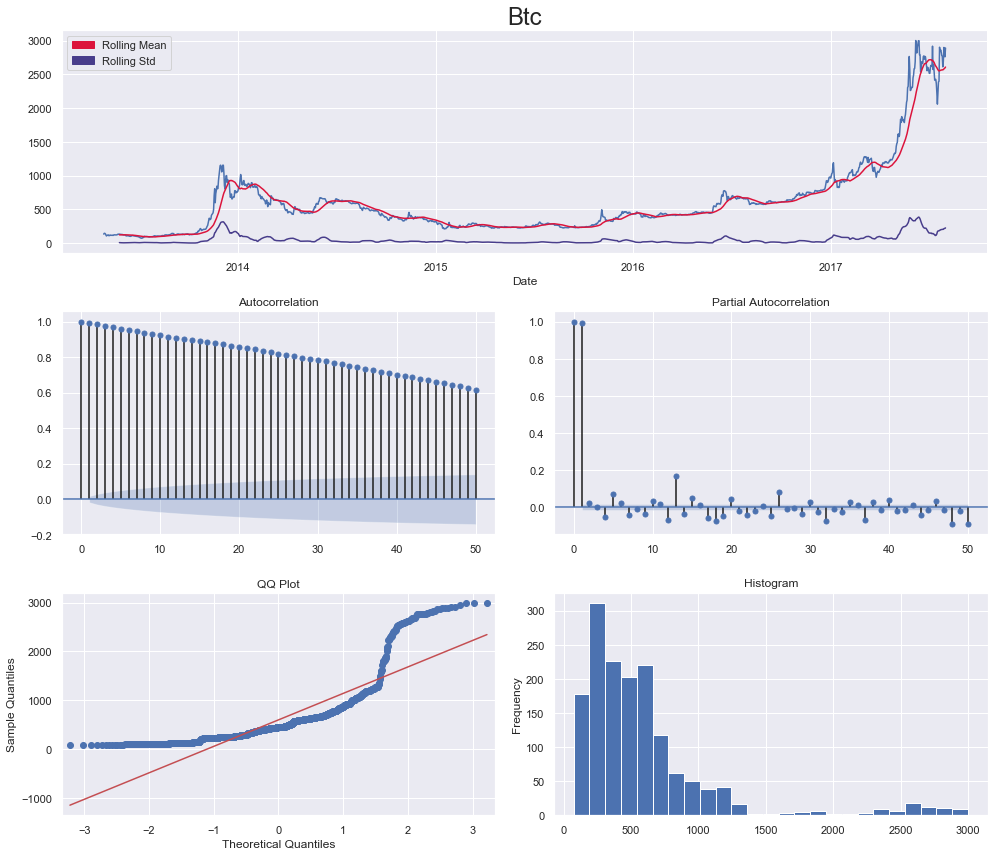

Results of Dickey-Fuller test:
test statistic             2.511750
p-value                    0.999054
# of lags                 24.000000
# of observations       1531.000000
Critical Value (1%)       -3.434628
Critical Value (5%)       -2.863430
Critical Value (10%)      -2.567776
dtype: float64


In [7]:
series = raw_price_data['High']
ts_diagnostics(series, lags=50, title='Btc')

### Conclusion
Because the **test statistic** is _above_ the **5% critical value** and the **p-value** is _larger_ than **0.05** the moving average is not constant over time. This means that the null hypothesis of the Augmented Dickey-Fuller test cannot be rejected, the series is not stationary. Though the graphic the mean is increasing even though the std is small. As mentioned above looking at the time plot of the data, on the ACF plot the data decreases slowly, configuring a non-stationary time series.


# Making the time series stationary
**Differencing** the series is one way to make the series stationary. **Transformations** such as logarithms can help to stabilise the variance of a time series. **Differencing** can help stabilise the mean of a time series by removing changes in the level of a time series, and therefore eliminating (or reducing) trend and seasonality.

- First-order differencing
- Second-order differencing
- Seasonal differencing

Reducing the trend using transformation, as we can see here that there is a strong positive trend. These transformation can be log, sq-rt, cube root etc . Basically it penalizes larger values more than the smaller. In this case we will use the logarithmic transformation.

## First Order Differencing

We assume that we can remove the trend from our data using first order differencing, however, note that differencing and detrending are two separate concepts.

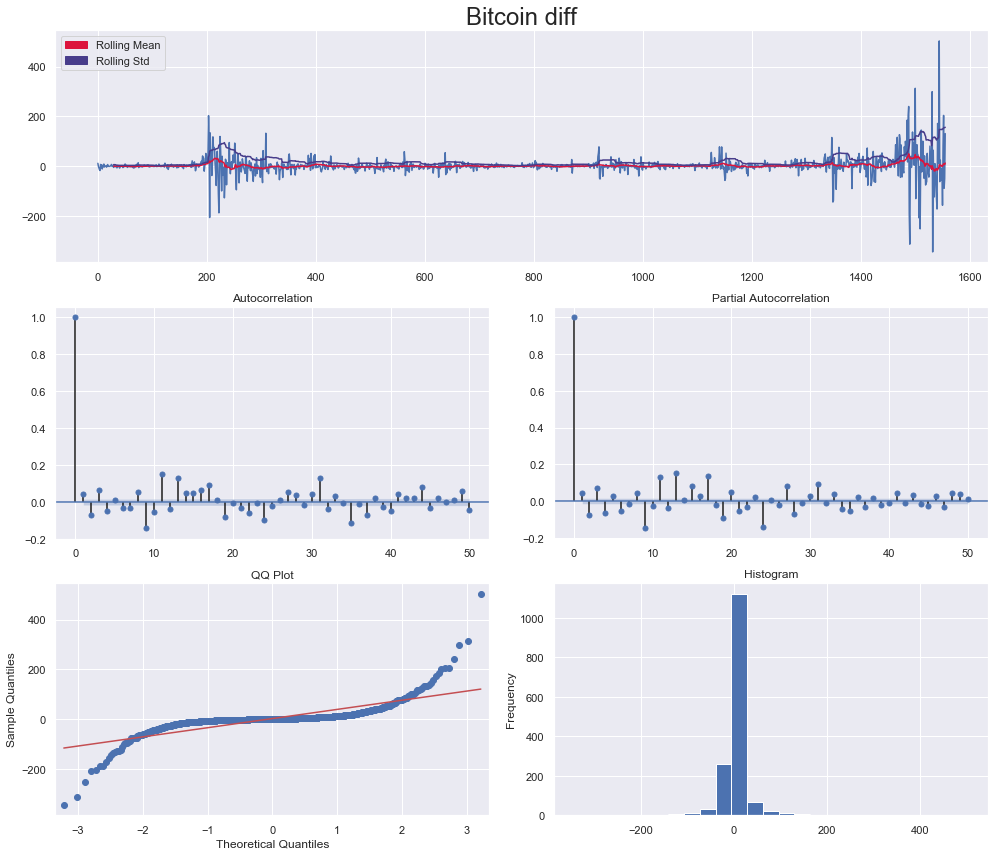

Results of Dickey-Fuller test:
test statistic         -7.647488e+00
p-value                 1.826219e-11
# of lags               2.300000e+01
# of observations       1.531000e+03
Critical Value (1%)    -3.434628e+00
Critical Value (5%)    -2.863430e+00
Critical Value (10%)   -2.567776e+00
dtype: float64


In [8]:
series = raw_price_data['High']
series_diff = np.diff(series)
ts_diagnostics(series_diff, lags=50, title='Bitcoin diff', filename='adf_diff')

## Second-order differencing
If the differenced data is still not stationary another differencing step can be included. This would indicate a higher order integration of the underlying process. We interpret the second level of differenced data as the “change of changes”. In practice it is typically not necessary to go beyond the second difference of a time series.

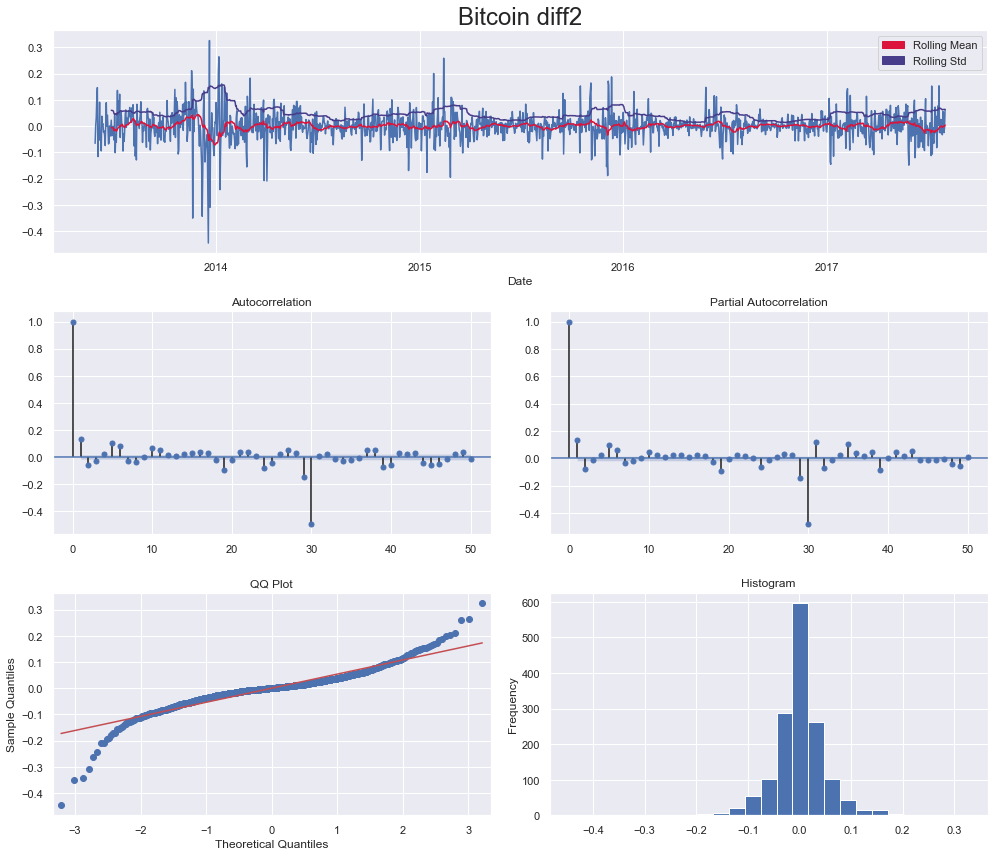

Results of Dickey-Fuller test:
test statistic         -1.366291e+01
p-value                 1.509503e-25
# of lags               5.000000e+00
# of observations       1.519000e+03
Critical Value (1%)    -3.434662e+00
Critical Value (5%)    -2.863445e+00
Critical Value (10%)   -2.567784e+00
dtype: float64


In [9]:
series = raw_price_data['High']
series_diff2 = np.log(series).diff().diff(30).dropna()
ts_diagnostics(series_diff2, lags=50, title='Bitcoin diff2')

## Seasonal differencing

A seasonal difference is the difference between an observation and the previous observation from the same season

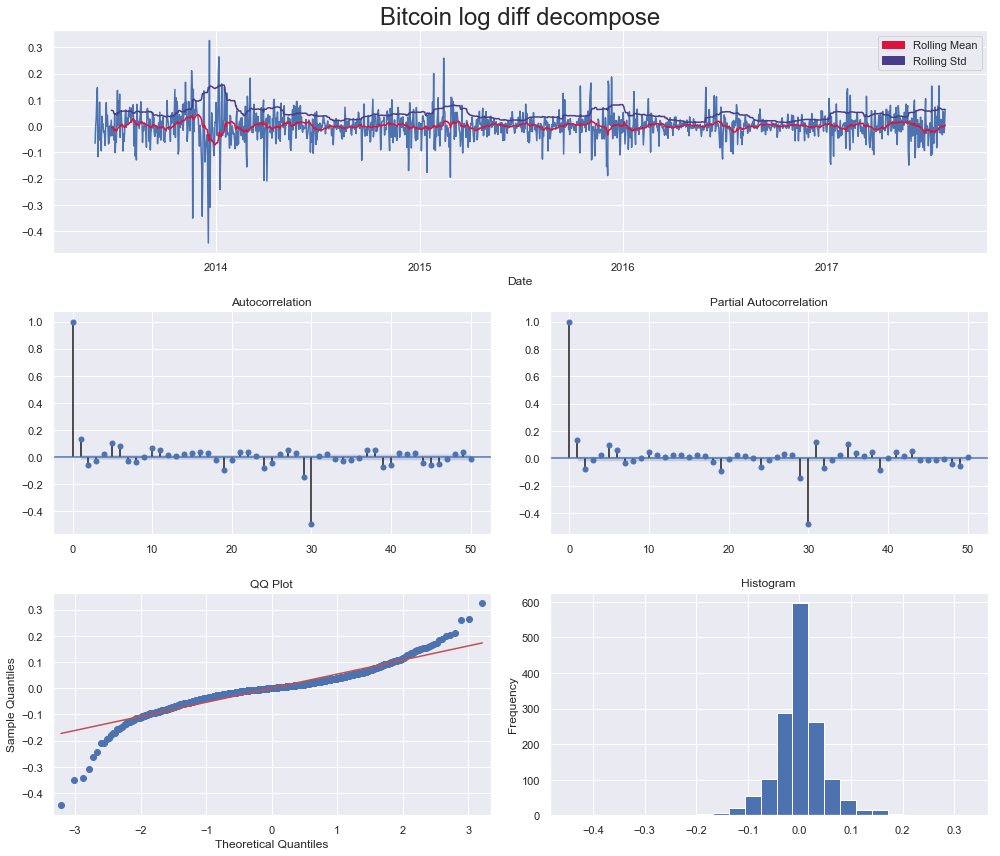

Results of Dickey-Fuller test:
test statistic         -1.366291e+01
p-value                 1.509503e-25
# of lags               5.000000e+00
# of observations       1.519000e+03
Critical Value (1%)    -3.434662e+00
Critical Value (5%)    -2.863445e+00
Critical Value (10%)   -2.567784e+00
dtype: float64


In [10]:
serie = raw_price_data['High']
serie_log_diff = np.log(serie).diff().dropna()
decomposition = sm.tsa.seasonal_decompose(serie_log_diff)
ts_log_decompose = decomposition.resid
ts_log_decompose.dropna(inplace=True)
ts_diagnostics(series_diff2, lags=50, title='Bitcoin log diff decompose')

# Building the model


## Model Identification (ARIMA Model Determination)
1. Determine the degree of differencing
2. Study the patterns of the ACF and PACF of the appropriately differenced series, as these autocorrelation functions will provide indication for the choice of the order of autoregressive and the moving average components.
3. The table below summarize the patterns of the ACF and PACF associated with the  AR(p),  MA(q), and  ARMA(p,q) processes:
Process	 |  ACF	 |  PACF
AR(p)	|  tails off  |	cutoff after lag  p
MA(q)	|cutoff after lag  qq   |	tails off
ARMA(p,q)	| tails off   |	tails off

Choosing training set and testing set. On time series you can't randomly choose observations for you training set, because if you do that you break the dependencie structure of your underline data. Therefore only the last part of the database will be used to make the forecast.


## Information Criteria
Akaike’s Information Criterion (AIC), which was useful in selecting predictors for regression, is also useful for determining the order of an ARIMA model. The Akaike information criterion (AIC) is a measure of the relative quality of statistical models for a given set of data. 

Also are Bayesian Information Criterion and corrected AIC. Good models are obtained by minimising the AIC, AICc or BIC.



### Statsmodels SARIMAX Model

In [11]:
import itertools

p_min = 0
d_min = 0
q_min = 0
p_max = 4
d_max = 0
q_max = 4

# Initialize a DataFrame to store the results
results_bic = pd.DataFrame(index=['AR{}'.format(i) for i in range(p_min,p_max+1)],
                           columns=['MA{}'.format(i) for i in range(q_min,q_max+1)])

for p,d,q in itertools.product(range(p_min,p_max+1),
                               range(d_min,d_max+1),
                               range(q_min,q_max+1)):
    if p==0 and d==0 and q==0:
        results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = np.nan
        continue
    
    try:
        model = sm.tsa.SARIMAX(series_diff2, order=(p, d, q), freq="D",
                               #enforce_stationarity=False,
                               #enforce_invertibility=False,
                              )
        results = model.fit()
        results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = results.bic
    except:
        continue
results_bic = results_bic[results_bic.columns].astype(float)

/home/sarai/.virtualenvs/hybrid-approach/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/sarai/.virtualenvs/hybrid-approach/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/sarai/.virtualenvs/hybrid-approach/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/sarai/.virtualenvs/hybrid-approach/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/sarai/.virtualenvs/hybrid-approach/lib/python3.6/site-packages

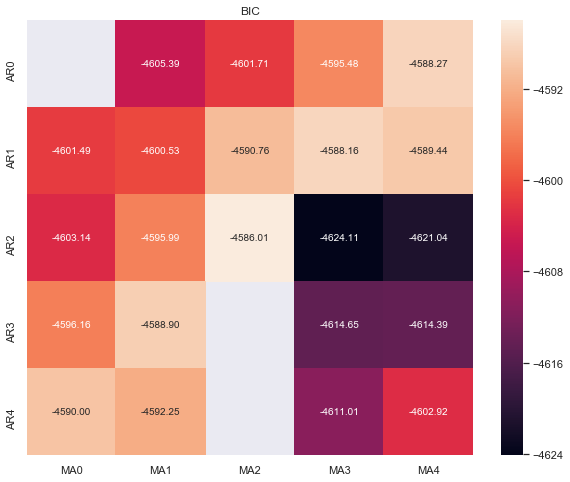

In [12]:
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(results_bic,
                 mask=results_bic.isnull(),
                 ax=ax,
                 annot=True,
                 fmt='.2f',
                 );
ax.set_title('BIC');

In [13]:
arima203 = sm.tsa.SARIMAX(series_diff2, order=(2, 0, 3), freq='D')
model_results = arima203.fit()
model_results.summary()

/home/sarai/.virtualenvs/hybrid-approach/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                   High   No. Observations:                 1525
Model:               SARIMAX(2, 0, 3)   Log Likelihood                2334.042
Date:                Tue, 02 Oct 2018   AIC                          -4656.084
Time:                        19:22:28   BIC                          -4624.106
Sample:                    05-29-2013   HQIC                         -4644.181
                         - 07-31-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8121      0.018     44.104      0.000       0.776       0.848
ar.L2         -0.9484      0.018    -54.168      0.000      -0.983      -0.914
ma.L1         -0.6807      0.024    -28.080      0.000      -0.728      -0.633
ma.L2          0.7825      0.028     27.501      0.000       0.727       0.838
ma.L3          0.1516      0.021      7.377      0.000       0.111       0.192
sigma2         0.0027   5.31e-05     51.628      0.000       0.003       0.003
===================================================================================
Ljung-Box (Q):                      419.60   Jarque-Bera (JB):              3941.03
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.39   Skew:                            -0.61
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

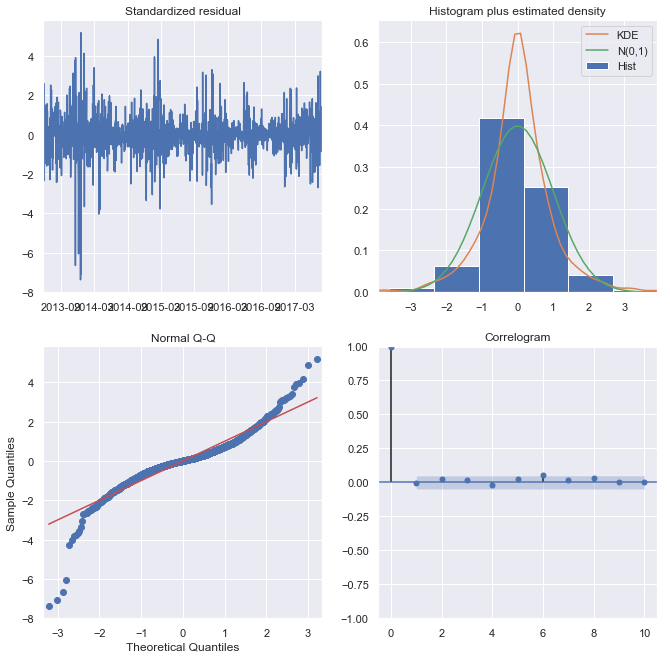

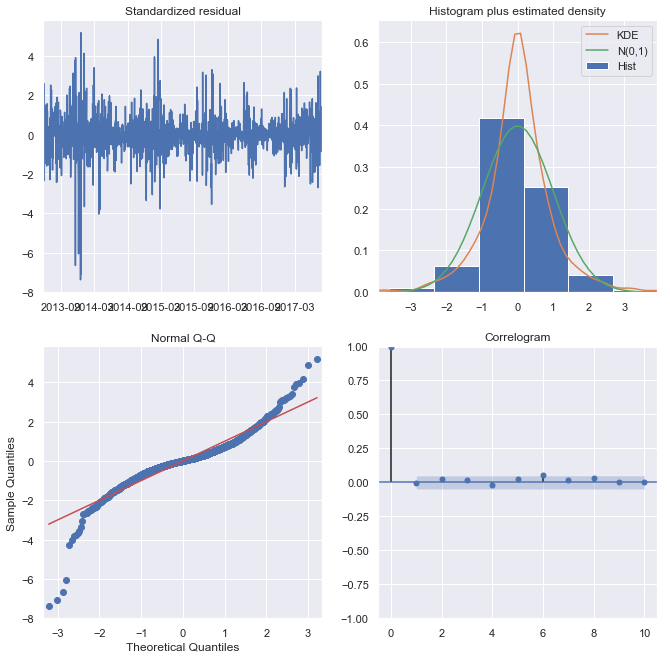

In [14]:
# Residual Diagnostics
# The plot_diagnostics function associated with the estimated result object produce a few plots that allow us 
# to examine the distribution and correlation of the estimated residuals

model_results.plot_diagnostics()

### Model performance evaluation (in-sample fit)

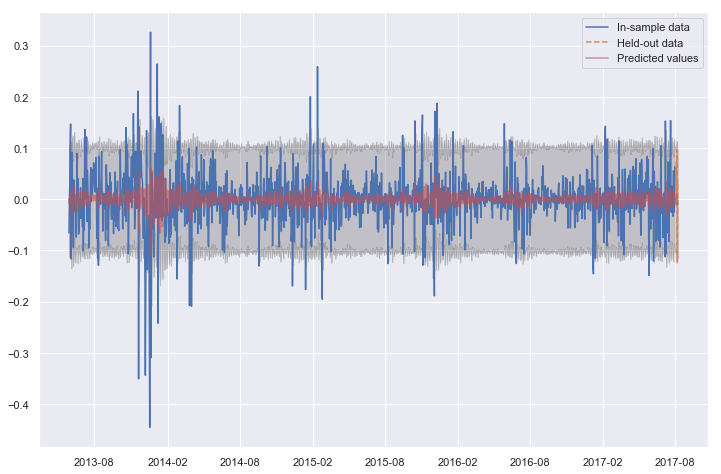

In [15]:
ts_train = series_diff2
ts_test = raw_price_test_data['High']
ts_test = np.log(ts_test).diff().diff(1).dropna()

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
    
ax1.plot(ts_train, label='In-sample data', linestyle='-')
# subtract 1 only to connect it to previous point in the graph
ax1.plot(ts_test, label='Held-out data', linestyle='--')

# yes DatetimeIndex
pred_begin = ts_train.index[model_results.loglikelihood_burn]
pred_end = ts_test.index[-1]
pred = model_results.get_prediction(start=pred_begin.strftime('%Y-%m-%d'),
                                    end=pred_end.strftime('%Y-%m-%d'))
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int(alpha=0.05)

ax1.plot(pred_mean, 'r', alpha=.6, label='Predicted values')
ax1.fill_between(pred_ci.index,
                 pred_ci.iloc[:, 0],
                 pred_ci.iloc[:, 1], color='k', alpha=.2)

ax1.legend(loc='best');

In [16]:
ts_train = series_diff2
rmse = get_rmse(ts_train, pred_mean.loc[ts_train.index])
print("RMSE: ", rmse)

mape = get_mape(ts_train, pred_mean.loc[ts_train.index])
print("MAPE: ", mape)

mase = get_mase(ts_train, pred_mean.loc[ts_train.index])
print("MASE: ", mase)

RMSE:  0.05237225299935484
MAPE:  196.40480064748527
MASE:  1.0005991233047304


In [17]:
# Forecasting and forecast evaluation

rmse = get_rmse(ts_test, pred_mean.loc[ts_test.index])
print("RMSE: ", rmse)

mape = get_mape(ts_test, pred_mean.loc[ts_test.index])
print("MAPE: ", mape)

mase = get_mase(ts_test, pred_mean.loc[ts_test.index])
print("MASE: ", mase)

RMSE:  0.0770810130057109
MAPE:  86.87808554321796
MASE:  1.032758999044171


### One step ahead prediction

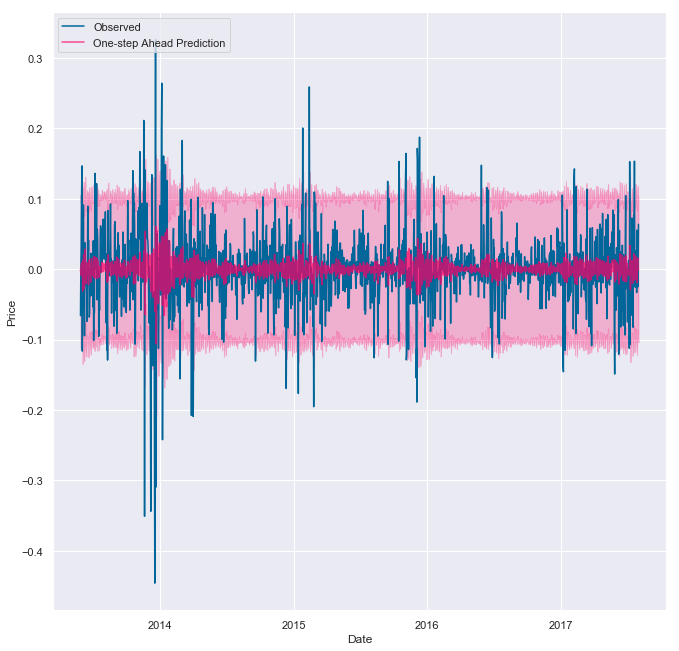

In [18]:
pred = model_results.get_prediction(dynamic=False)
pred_ci = pred.conf_int()

# plot in-sample-prediction
ax = series_diff2.plot(label='Observed',color='#006699')
pred.predicted_mean.plot(ax=ax, label='One-step Ahead Prediction', alpha=.7, color='#ff0066')

# draw confidence bound (gray)
ax.fill_between(pred_ci.index, 
                pred_ci.iloc[:, 0], 
                pred_ci.iloc[:, 1], color='#ff0066', alpha=.25)

# style the plot
# ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('1958-12-01'), y.index[-1], alpha=.15, zorder=-1, color='grey');
ax.set_xlabel('Date');
ax.set_ylabel('Price');
plt.legend(loc='upper left');
plt.show()

### Out of sample prediction

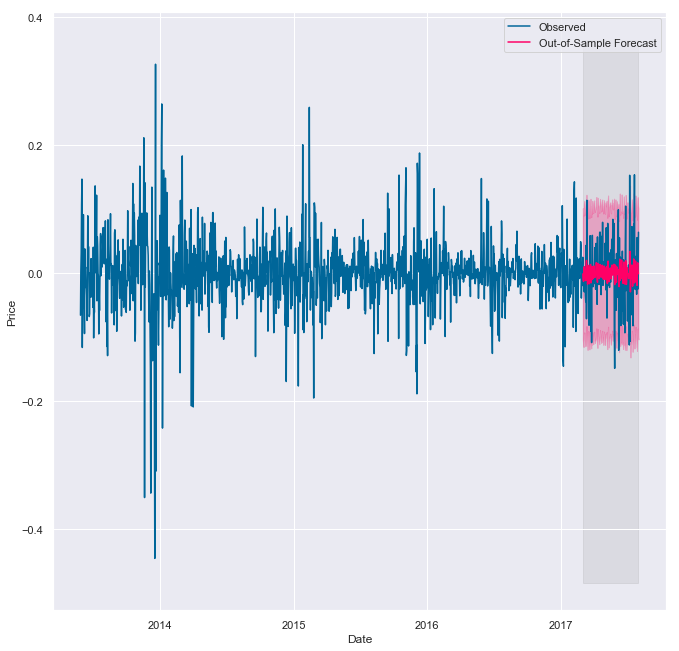

In [19]:
pred_out = model_results.get_prediction(start=pd.to_datetime('2017-03-01'), 
                                       dynamic=False, full_results=True)
pred_out_confidence_interval = pred_out.conf_int()

ax = series_diff2.plot(label='Observed', color='#006699')
pred_out.predicted_mean.plot(ax=ax, label='Out-of-Sample Forecast', color='#ff0066')
ax.fill_between(pred_out_confidence_interval.index,
                pred_out_confidence_interval.iloc[:, 0],
                pred_out_confidence_interval.iloc[:, 1], color='#ff0066', alpha=.25)
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2017-03-01'), series_diff2.index[-1], alpha=.15, zorder=-1, color='grey')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.legend()
plt.show()


Prediction quality: 0.00 MSE (0.05 RMSE)


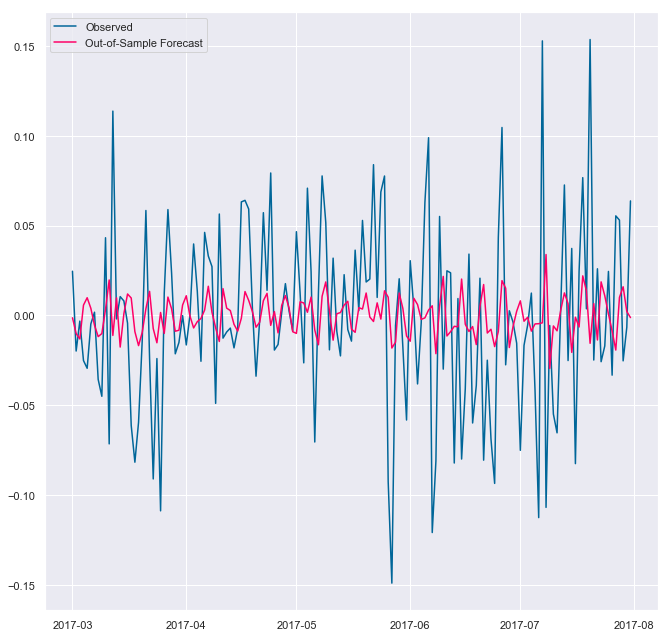

In [20]:
import math
y_hat = pred_out.predicted_mean
y_true = series_diff2['2017-03-01':]

# compute the mean square error
mse = ((y_hat - y_true) ** 2).mean()
print('Prediction quality: {:.2f} MSE ({:.2f} RMSE)'.format(mse, math.sqrt(mse)))

plt.plot(y_true, label='Observed', color='#006699')
plt.plot(y_hat, label='Out-of-Sample Forecast', color='#ff0066')
ax.set_xlabel('Date')
ax.set_ylabel('Passengers')
plt.legend(loc='upper left');
plt.show()

### Long Term Forecast

/home/sarai/.virtualenvs/hybrid-approach/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


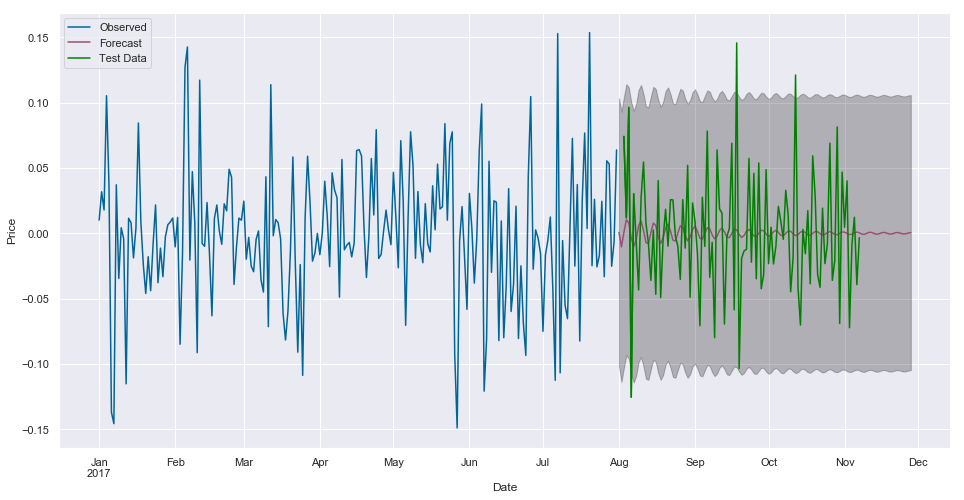

In [21]:
arima203 = sm.tsa.SARIMAX(series_diff2, order=(2, 0, 3), freq='D')
model_results = arima203.fit()

ts_test = raw_price_test_data['High']
ts_test = np.log(ts_test).diff().diff(1).dropna()

ts_what_really_happened = what_really_happened['High']
ts_what_really_happened = np.log(ts_what_really_happened).diff().diff(1).dropna()


# get forecast 120 steps ahead in future
pred_uc = model_results.get_forecast(steps=120)
# get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

# plot time series and long-term forecast
ax = series_diff2.loc['2017':].plot(label='Observed', figsize=(16, 8), color='#006699')

# pred_out = model_results.get_prediction(start=pd.to_datetime('2017-03-01'), 
#                                        dynamic=False, full_results=True)
# pred_out_confidence_interval = pred_out.conf_int()
# pred_out.predicted_mean.plot(ax=ax, label='One step ahead forecast', color='#ff0066')
# ax.fill_between(pred_out_confidence_interval.index,
#                 pred_out_confidence_interval.iloc[:, 0],
#                 pred_out_confidence_interval.iloc[:, 1], color='#ff0066', alpha=.25)

pred_uc.predicted_mean.plot(ax=ax, label='Forecast', color='#975075')
ts_test.plot(ax=ax, label="Test Data", color="green")
ts_what_really_happened.plot(ax=ax, label="", color="green")
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='black', alpha=.25);

ax.set_xlabel('Date');
ax.set_ylabel('Price');
plt.legend(loc='upper left')
plt.show()

In [22]:
print(type(ts_test))
print(ts_test)

<class 'pandas.core.series.Series'>
Date
2017-08-03    0.074114
2017-08-04    0.011903
2017-08-05    0.096293
2017-08-06   -0.125414
2017-08-07    0.030209
Name: High, dtype: float64


In [23]:
# pred_mean = pred_uc

#rmse = get_rmse(ts_train, pred_mean.ix[ts_train.index])
#print("RMSE: ", rmse)

#mape = get_mape(ts_train, pred_mean.ix[ts_train.index])
#print("MAPE: ", mape)

#mase = get_mase(ts_train, pred_mean.ix[ts_train.index])
#print("MASE: ", mase)

### Statsmodel ARIMA Model

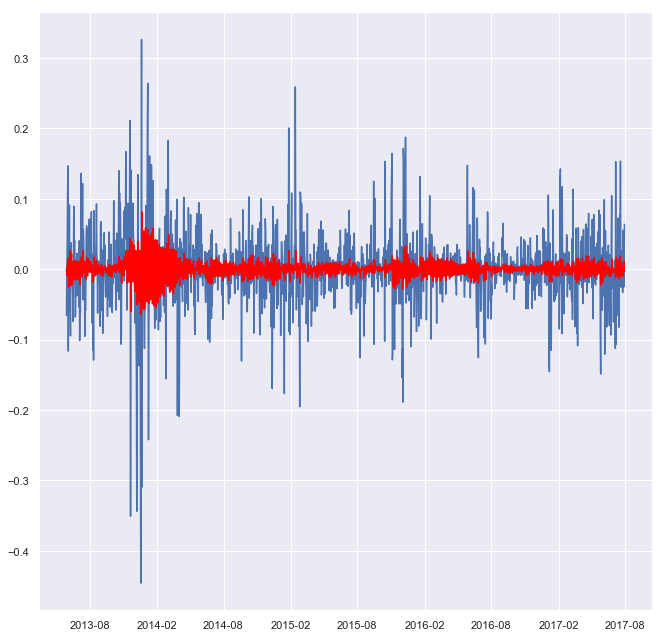

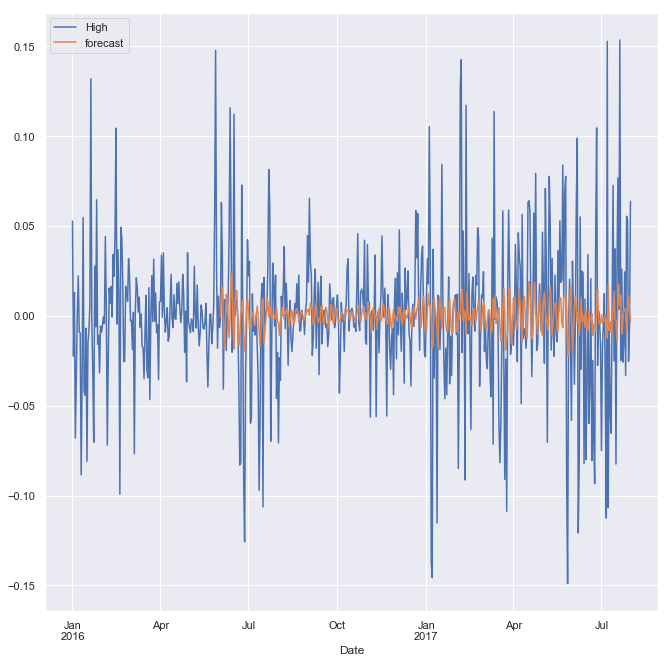

<Figure size 1080x720 with 0 Axes>

In [24]:
new_series_diff2 = np.array(series_diff2)
arima203 = sm.tsa.ARIMA(series_diff2, order=(3, 0, 2), freq='D')
model_results = arima203.fit(disp=-1)

plt.plot(series_diff2)
plt.plot(model_results.fittedvalues, color="red")

fig, ax = plt.subplots()
ax = series_diff2.loc['2016':].plot(ax=ax)
fig = model_results.plot_predict(start='2016-06-02', plot_insample=False, ax=ax)
plt.figure(figsize=(15,10))
plt.show()

### PyFlux ARIMA model

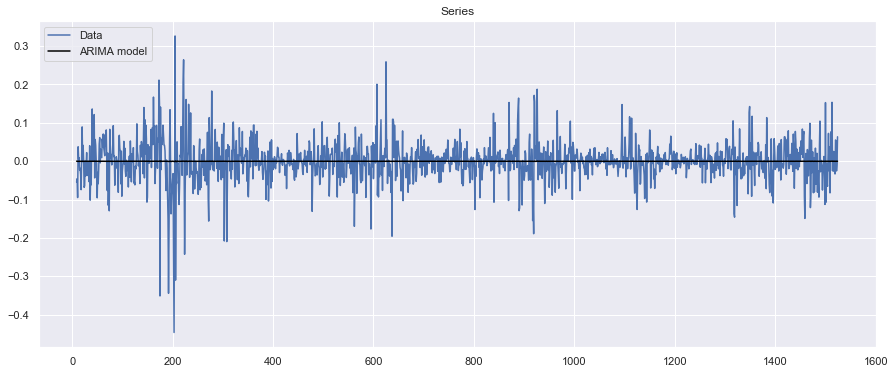

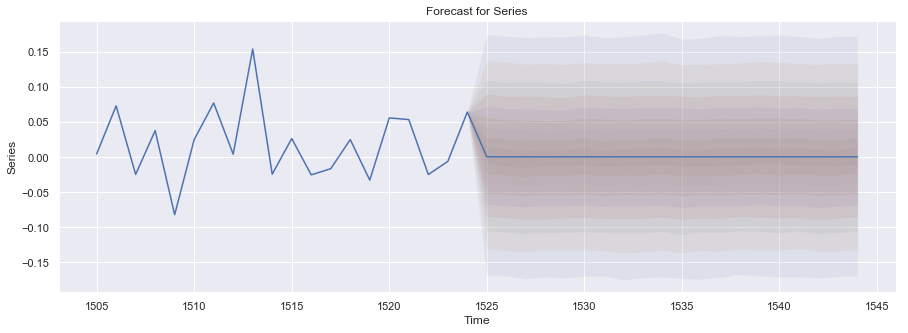

In [25]:
new_series_diff2 = np.array(series_diff2)
model = pf.ARIMA(ar=9, ma=2, data=new_series_diff2, target=1)
# The distribution for the time series
model.adjust_prior([0], pf.Exponential())
# maximum likelihood point | is a method of estimating the parameters of a statistical model given observations, 
# by finding the parameter values that maximize the likelihood of making the observations given the parameters.
x = model.fit('MLE', nsims=50000)
model.plot_fit(figsize=(15,6))
# h = How many steps to forecast ahead
model.plot_predict(h=20,past_values=20,figsize=(15,5))

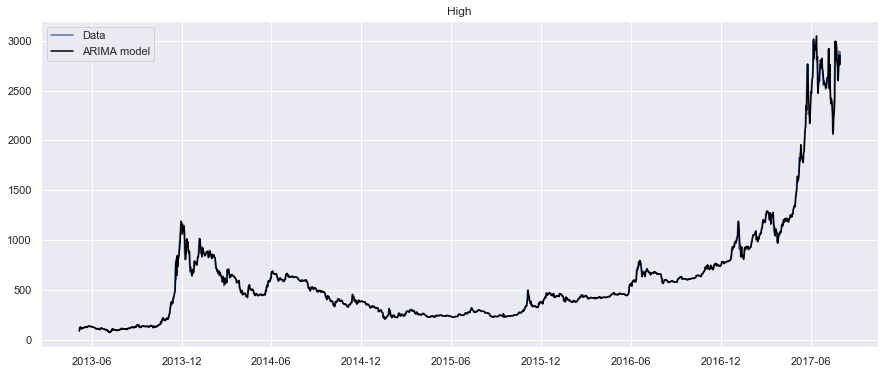

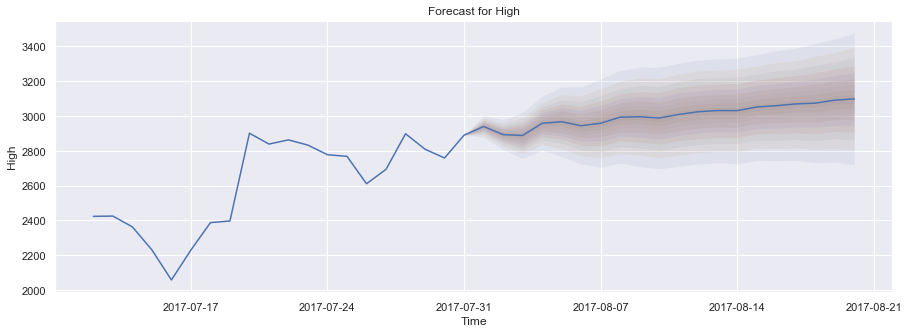

In [26]:
model = pf.ARIMA(ar=9, ma=2, data=raw_price_data, target='High')
# The distribution for the time series
model.adjust_prior([0], pf.Exponential())
# maximum likelihood point | is a method of estimating the parameters of a statistical model given observations, 
# by finding the parameter values that maximize the likelihood of making the observations given the parameters.
x = model.fit('MLE', nsims=50000)
model.plot_fit(figsize=(15,6))
# h = How many steps to forecast ahead
model.plot_predict(h=20,past_values=20,figsize=(15,5))

### Evaluating the Model Fit

# Prophet

Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

Prophet is used in many applications across Facebook for producing reliable forecasts for planning and goal setting. We’ve found it to perform better than any other approach in the majority of cases.

At its core, the Prophet procedure is an additive regression model with four main components:

- A piecewise linear or logistic growth curve trend. Prophet automatically detects changes in trends by selecting changepoints from the data.
- A yearly seasonal component modeled using Fourier series.
- A weekly seasonal component using dummy variables.
- A user-provided list of important holidays.

In [27]:
from fbprophet import Prophet

n = pd.DataFrame({'ds': raw_price_data['High'].index, 'y': raw_price_data['High'].values})

m = Prophet(interval_width=0.95, daily_seasonality=True)
m.fit(n)

future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

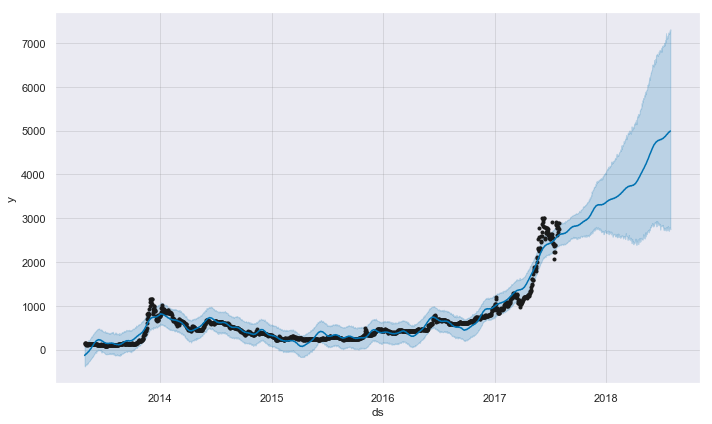

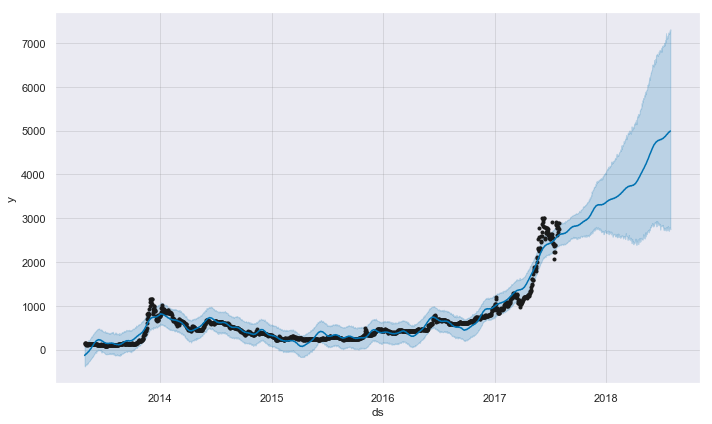

In [28]:
m.plot(forecast, uncertainty=True)
#raw_price_test_data['High'].plot(label="Test Data", color="green")

### Evaluating the Model Fit

# Neural Networks 
Long-Short-Term-Memory (LSTM) networks using `keras` with `tensorflow` backend.


Artificial neural networks (ANNs) are computing systems inspired by the biological neural networks that constitute bilological brains. Such systems learn (progressively improve performance) to do tasks by considering examples, generally without task-specific programming (if-then clauses).


An ANN is based on a collection of connected units called Perceptrons analogous to neurons in a biological brain. Each connection (synapse) between neurons can transmit a signal to another neuron. The receiving (postsynaptic) neuron can process the signal(s) and then signal downstream neurons connected to it. – Wikipedia


Long short-term memory (LSTM) is a recurrent neural network (RNN) architecture that remembers values over arbitrary intervals. Stored values are not modified as learning proceeds. RNNs allow forward and backward connections between neurons. An LSTM is well-suited to classify, process and predict time series given time lags of unknown size and duration between important events. – Wikipedia

In [29]:
seq_len = 1
d = 0.2
layers = [4, seq_len, 1] # feature, window, output
neurons = [128, 128, 32, 1]
epochs = 300

In [30]:
df = raw_price_data
df.drop(['Volume', 'Market Cap'], 1, inplace=True)

min_max_scaler = MinMaxScaler()
df['Open'] = min_max_scaler.fit_transform(df.Open.values.reshape(-1,1))
df['High'] = min_max_scaler.fit_transform(df.High.values.reshape(-1,1))
df['Low'] = min_max_scaler.fit_transform(df.Low.values.reshape(-1,1))
df['Close'] = min_max_scaler.fit_transform(df.Low.values.reshape(-1,1))


In [31]:
df.head()

,Open,High,Low,Close
Date,,,,
2013-04-28,0.023156,0.020996,0.023989,0.023989
2013-04-29,0.022858,0.024930,0.024674,0.024674
2013-04-30,0.026172,0.024739,0.024692,0.024692
2013-05-01,0.024439,0.022332,0.015204,0.015204
2013-05-02,0.016598,0.017447,0.009640,0.009640


In [32]:
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.as_matrix() 
    sequence_length = seq_len + 1 # index starting from 0
    result = []
    
    for index in range(len(data) - sequence_length): # maxmimum date = lastest date - sequence length
        result.append(data[index: index + sequence_length]) # index : index + 1day
    
    result = np.array(result)
    row = round(0.9 * result.shape[0]) # 90% split
    
    train = result[:int(row), :] # 90% date
    X_train = train[:, :-1] # all data until day m
    y_train = train[:, -1][:,-1] # day m + 1
    
    X_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1] 


    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))  

    return [X_train, y_train, X_test, y_test]

In [33]:
x_train, y_train, x_test, y_test = load_data(df, 1)

In [34]:
model = Sequential()
model.add(LSTM(neurons[0], input_shape=(layers[1], layers[0]), return_sequences=True))
model.add(LSTM(neurons[1], input_shape=(layers[1], layers[0]), return_sequences=False))
model.add(Dense(neurons[2],kernel_initializer="uniform",activation='relu'))        
model.add(Dense(neurons[3],kernel_initializer="uniform",activation='linear'))

model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])

model.fit(x_train, y_train, batch_size=512, epochs=epochs, validation_split=0.1, verbose=0, shuffle=False)

In [35]:
train_score = model.evaluate(x_train, y_train, verbose=0)
print('Train Score: %.5f MSE (%.2f RMSE)' % (train_score[0], math.sqrt(train_score[0])))

test_score = model.evaluate(x_test, y_test, verbose=0)
print('Test Score: %.5f MSE (%.2f RMSE)' % (test_score[0], math.sqrt(test_score[0])))

Train Score: 0.00009 MSE (0.01 RMSE)
Test Score: 0.00697 MSE (0.08 RMSE)


In [36]:
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

<class 'numpy.ndarray'>


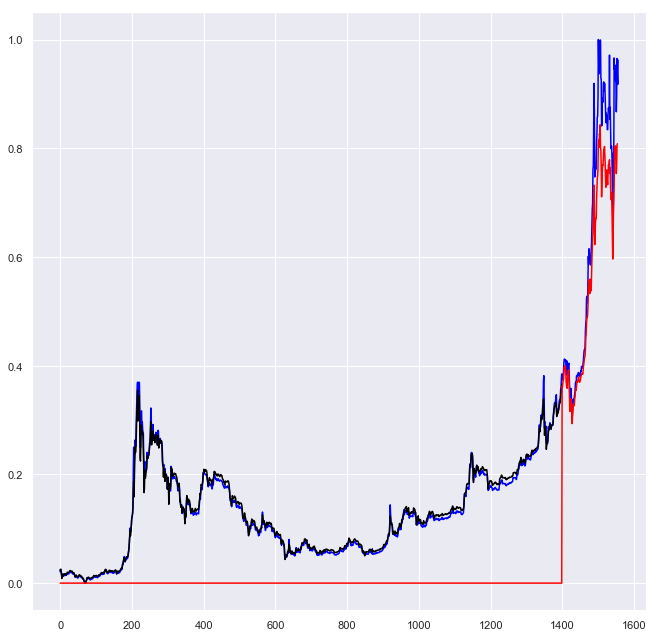

In [37]:
print(type(test_predict))
len(train_predict)
r = [[0]] * 1399

result = np.append(r, test_predict)

plt.plot(df["High"].values, color='blue', label='Actual')
plt.plot(train_predict, color='black', label='One Step Ahead')
plt.plot(result, color='red', label='Prediction')

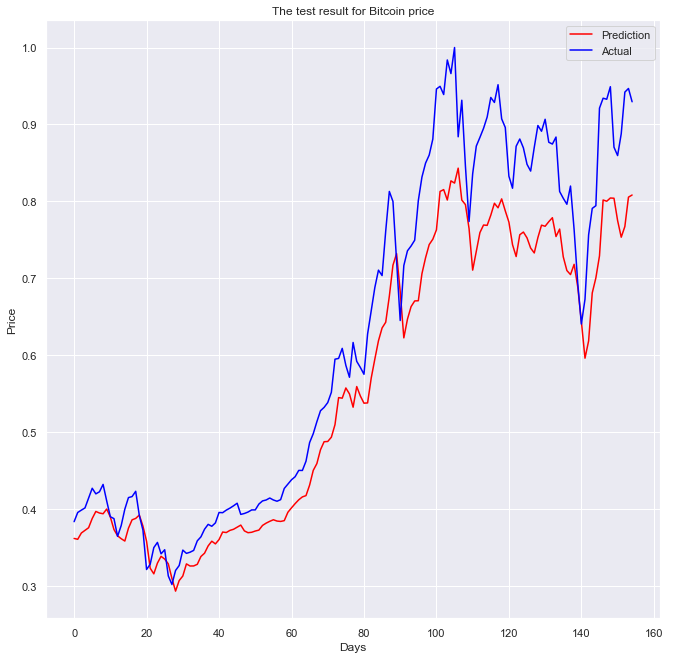

In [38]:
plt.plot(test_predict, color='red', label='Prediction')
plt.plot(y_test,color='blue', label='Actual')
plt.legend(loc='best')
plt.title('The test result for {}'.format("Bitcoin price"))
plt.xlabel('Days')
plt.ylabel('Price')
plt.show()

## References
- https://otexts.org/fpp2/
- https://github.com/etcrago/Tutorial-Arima-w-jeffrey-yau/blob/master/Section_2_ARIMA_Models_tutorial.ipynb 
- https://www.youtube.com/watch?v=_vQ0W_qXMxk 
- http://dacatay.com/data-science/comprehensive-guide-time-series-analytics-visualization-prediction-python/
- https://www.alanzucconi.com/2016/06/06/autocorrelation-function/